In [1]:
!pip install segmentation_models
!pip install keras==2.3.1
!pip install tensorflow==2.1.0
!pip install keras_applications==1.0.8
!pip install image-classifiers==1.0.0
!pip install efficientnet==1.0.0

!pip install opencv-python
!pip install opencv-contrib-python

!pip install -q git+https://github.com/tensorflow/examples.git

     |████████████████████████████████| 51kB 3.4MB/s 
     |████████████████████████████████| 378kB 2.8MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 3.9MB 36.3MB/s 
     |████████████████████████████████| 450kB 34.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=84b5c800fbf4babb0e901b4fa3185fa740a8598f593f064b898f5506a2328e5e
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tenso

In [1]:
import numpy as np
import pandas as pd
import h5py
import cv2
#from os import walk, makedir
import os
from os.path import join, exists
import matplotlib.pyplot as plt
#import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger
import segmentation_models as sm
#from tqdm import tqdm
from segmentation_models.metrics import f1_score, iou_score
# from skimage import filters
# import glob
# import re

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Segmentation Models: using `tf.keras` framework.


In [2]:
#data = h5py.File('drive/MyDrive/Transsytosis/compiled_data.h5', 'r')
data = h5py.File('mix_data.h5', 'r')

In [3]:
X_train, X_val, y_train, y_val = data['X_train'], data['X_val'], data['y_train'], data['y_val']
print(X_train.shape, X_train.dtype)
print(X_val.shape, X_val.dtype)
print(y_train.shape, y_train.dtype)
print(y_val.shape, y_val.dtype)

(506, 1024, 1088, 1) float32
(104, 1024, 1088, 1) float32
(506, 1024, 1088, 1) uint8
(104, 1024, 1088, 1) uint8


In [2]:
files = ['random_45_rotation_data.h5','shear_data.h5','arc_data.h5']#'compiled_data.h5','arc_data.h5','shear_data.h5','random_45_rotation_data.h5','vertical_flip_data.h5','horizontal_flip_data.h5'
train_seq = np.array([])
val_seq = np.array([])
nt = 506//len(files)
nv = 104//len(files)
for i in range(len(files)):
    train_seq = np.concatenate((train_seq,np.ones(nt)*i))
    val_seq = np.concatenate((val_seq,np.ones(nv)*i))
train_eles = (506 - len(train_seq))
val_eles = (104 - len(val_seq))
if train_eles > 0:
    train_seq = np.concatenate((train_seq,np.zeros(train_eles)))
if val_eles > 0:
    val_seq = np.concatenate((val_seq,np.zeros(val_eles)))
np.random.shuffle(train_seq)
np.random.shuffle(val_seq)

count = 0
X_train_conc = []
y_train_conc = []
for file in files:
    data = h5py.File(file, 'r')
    X_train, X_val, y_train, y_val = data['X_train'], data['X_val'], data['y_train'], data['y_val']
    for i,num in zip(np.arange(506),train_seq):
        if num == count:
            X_train_conc.append(X_train[i,...,0])
            y_train_conc.append(y_train[i,...,0])
    count += 1
X_train_shuffled = np.array(X_train_conc).reshape((506,1024,1088,1))
y_train_shuffled = np.array(y_train_conc).reshape((506,1024,1088,1))

count = 0
X_val_conc = []
y_val_conc = []
for file in files:
    data = h5py.File(file, 'r')
    X_train, X_val, y_train, y_val = data['X_train'], data['X_val'], data['y_train'], data['y_val']
    for i,num in zip(np.arange(104),val_seq):
        if num == count:
            X_val_conc.append(X_val[i,...,0])
            y_val_conc.append(y_val[i,...,0])
    count += 1
X_val_shuffled = np.array(X_val_conc).reshape((104,1024,1088,1))
y_val_shuffled = np.array(y_val_conc).reshape((104,1024,1088,1))

X_train = X_train_shuffled
y_train = y_train_shuffled
X_val = X_val_shuffled
y_val = y_val_shuffled

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(506, 1024, 1088, 1)
(506, 1024, 1088, 1)
(104, 1024, 1088, 1)
(104, 1024, 1088, 1)


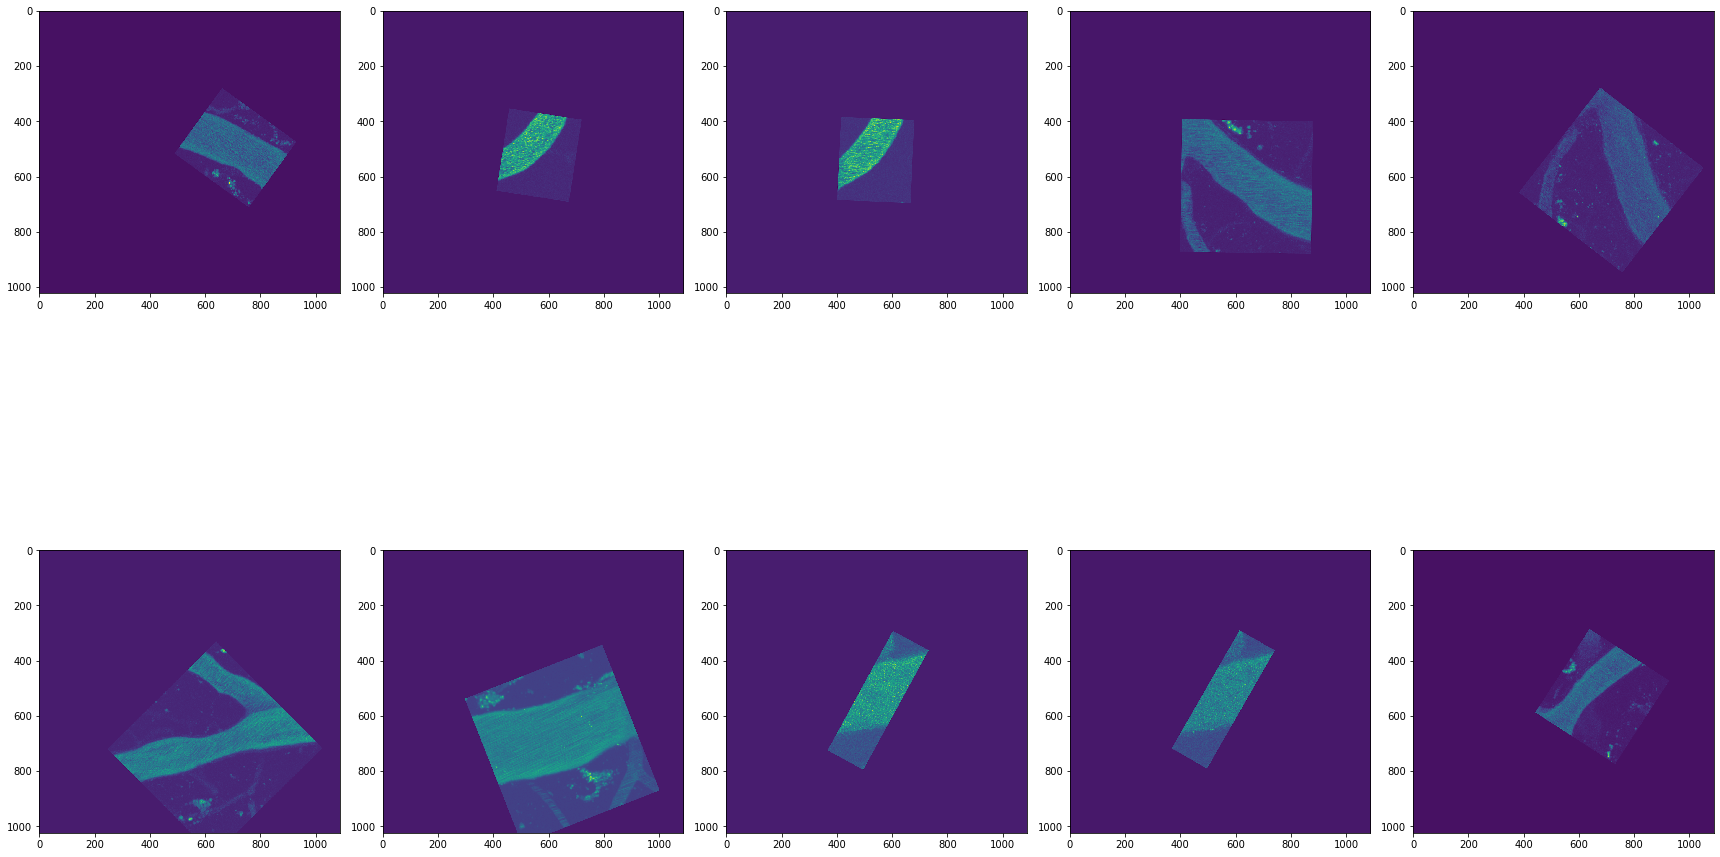

In [3]:
fig, axes = plt.subplots(2,5,figsize=(24,18))
idx = 15
for i, ax in enumerate(zip(*axes)):
    ax[0].imshow(X_train[idx+i,...,0])
    ax[1].imshow(X_val[idx+i,...,0])
fig.tight_layout()
plt.show()

In [4]:
n,h,w,_ = X_train.shape
resize_factor = 2
X_train_resized = []

for i in range(n):
  resized = cv2.resize(X_train[i,...,0], dsize=(w//resize_factor, h//resize_factor), interpolation=cv2.INTER_CUBIC)
  X_train_resized.append(resized)
X_train_resized = np.array(X_train_resized)
X_train_resized = np.expand_dims(X_train_resized, -1)
#X_train_resized.resize((506,256,272,1))

n,h,w,_ = y_train.shape
y_train_resized = []

for i in range(n):
  resized = cv2.resize(y_train[i,...,0], dsize=(w//resize_factor,h//resize_factor), interpolation=cv2.INTER_NEAREST)
  y_train_resized.append(resized)
y_train_resized = np.array(y_train_resized)
#y_train_resized.resize((506,h//resize_factor,w//resize_factor,1))
y_train_resized = np.expand_dims(y_train_resized, -1)

n,h,w,_ = X_val.shape
X_val_resized = []

for i in range(n):
  resized = cv2.resize(X_val[i,...,0], dsize=(w//resize_factor,h//resize_factor), interpolation=cv2.INTER_CUBIC)
  X_val_resized.append(resized)
X_val_resized = np.array(X_val_resized)
#X_val_resized.resize((104,h//resize_factor,w//resize_factor,1))
X_val_resized = np.expand_dims(X_val_resized, -1)

n,h,w,_ = y_val.shape
y_val_resized = []

for i in range(n):
  resized = cv2.resize(y_val[i,...,0], dsize=(w//resize_factor,h//resize_factor), interpolation=cv2.INTER_NEAREST)
  y_val_resized.append(resized)
y_val_resized = np.array(y_val_resized)
#y_val_resized.resize((104,h//resize_factor,w//resize_factor,1))
y_val_resized = np.expand_dims(y_val_resized, -1)

In [5]:
# X_val_resized = X_val
# y_val_resized = y_val
print(X_train.shape)
print(X_train_resized.shape)

print(y_train.shape)
print(y_train_resized.shape)

print(X_val.shape)
print(X_val_resized.shape)

print(y_val.shape)
print(y_val_resized.shape)

(506, 1024, 1088, 1)
(506, 512, 544, 1)
(506, 1024, 1088, 1)
(506, 512, 544, 1)
(104, 1024, 1088, 1)
(104, 512, 544, 1)
(104, 1024, 1088, 1)
(104, 512, 544, 1)


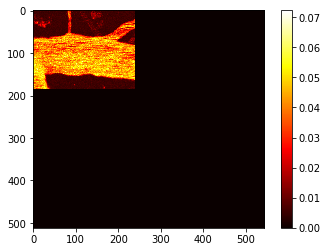

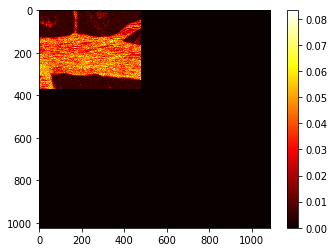

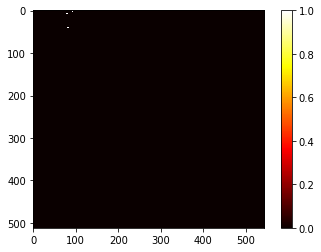

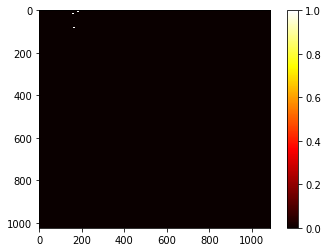

In [6]:
plt.imshow(X_train_resized[1,...,0],cmap='hot')
plt.colorbar()
plt.show()
plt.imshow(X_train[1,...,0],cmap='hot')
plt.colorbar()
plt.show()

plt.imshow(y_train_resized[1,...,0],cmap='hot')
plt.colorbar()
plt.show()
plt.imshow(y_train[1,...,0],cmap='hot')
plt.colorbar()
plt.show()

In [7]:
np.unique(y_train_resized[1,...,0])

array([0, 1], dtype=uint8)

In [6]:
X_train_resized_pre = X_train_resized
print(X_train_resized_pre.shape)
add_layer = X_train_resized
print(add_layer.shape)
X_train_resized_pre = np.concatenate([X_train_resized_pre, add_layer], axis=3)
X_train_resized_pre = np.concatenate([X_train_resized_pre, add_layer], axis=3)
print(X_train_resized_pre.shape)

print(X_train_resized_pre[0,0,0,0])
print(X_train_resized_pre[0,0,0,1])
print(X_train_resized_pre[0,0,0,2])

X_val_resized_pre = X_val_resized
print(X_val_resized_pre.shape)
add_layer = X_val_resized
print(add_layer.shape)
X_val_resized_pre = np.concatenate([X_val_resized_pre, add_layer], axis=3)
X_val_resized_pre = np.concatenate([X_val_resized_pre, add_layer], axis=3)
print(X_val_resized_pre.shape)

print(X_val_resized_pre[0,0,0,0])
print(X_val_resized_pre[0,0,0,1])
print(X_val_resized_pre[0,0,0,2])

(506, 512, 544, 1)
(506, 512, 544, 1)
(506, 512, 544, 3)
0.0
0.0
0.0
(104, 512, 544, 1)
(104, 512, 544, 1)
(104, 512, 544, 3)
0.0
0.0
0.0


In [7]:
#resize_factor = 1
model_input_size = (1024//resize_factor, 1088//resize_factor)

model = sm.Unet( 
    'resnet18',
    classes=1,
    activation='sigmoid',
    encoder_weights='imagenet',
    input_shape=(1024//resize_factor, 1088//resize_factor,3),
    decoder_block_type='transpose'
)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss= sm.losses.dice_loss,
    metrics=[f1_score]
)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 512, 544, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 512, 544, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 518, 550, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 272, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [8]:
model = tf.keras.models.load_model('./UnetImagenetModel/model.063-0.4602.h5')

In [ ]:
log_data = pd.read_csv('./drive/MyDrive/Transsytosis/LinknetImagenetModel/training.log', sep=',', engine='python')

OSError: ignored

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    elif epoch < 200:
        return 0.00001
    else:
        return lr

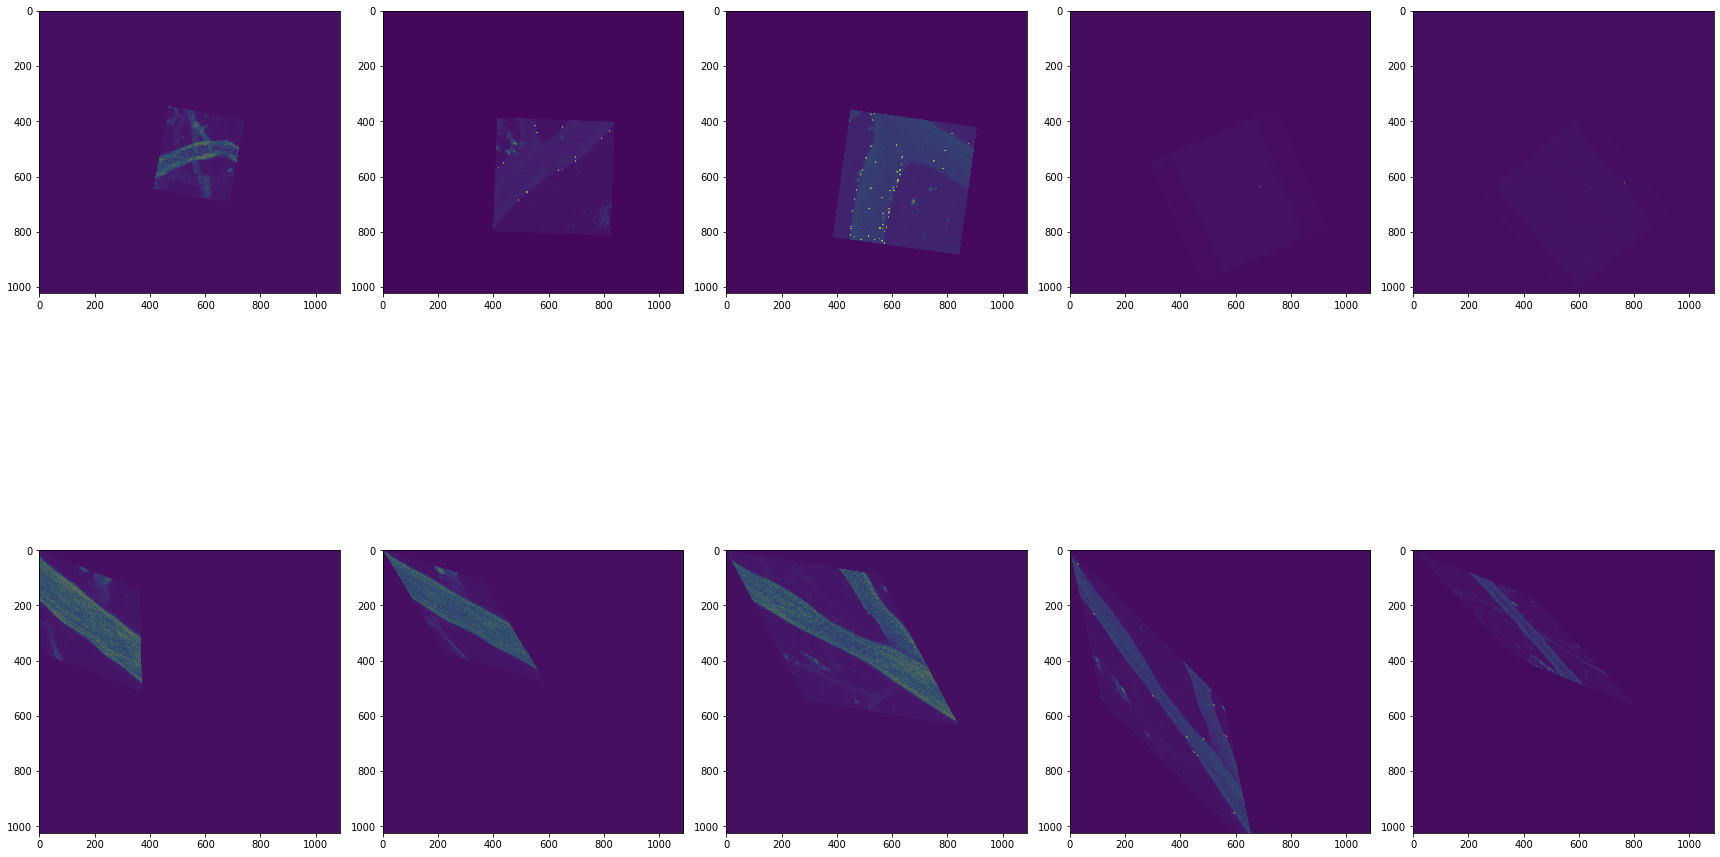

In [8]:
y_train_resized = np.float32(y_train_resized)
y_val_resized = np.float32(y_val_resized)

fig, axes = plt.subplots(2,5,figsize=(24,18))
idx = 40
for i, ax in enumerate(zip(*axes)):
    ax[0].imshow(X_train[idx+i,...,0])
    ax[1].imshow(X_val[idx+i,...,0])
    ax[0].imshow(y_train[idx+i,...,0],alpha=0.5)
    ax[1].imshow(y_val[idx+i,...,0],alpha=0.5)
fig.tight_layout()
plt.show()

In [9]:
EPOCHS = 100 #113
BATCH_SIZE = 20
TRAINSET_SIZE = 506
VALSET_SIZE = 104

STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

csv_logger = CSVLogger('./UnetImagenetArcRotationShearModel/training.log', separator=',', append=False)

model_history = model.fit(X_train_resized_pre, 
                          y_train_resized, 
                          epochs=EPOCHS, 
                          batch_size=BATCH_SIZE,
                          validation_data=(X_val_resized_pre, y_val_resized),
                          callbacks=[
                              ModelCheckpoint(filepath=join('./UnetImagenetArcRotationShearModel','model.{epoch:03d}.h5')),
                              csv_logger,
                              #LearningRateScheduler(scheduler)
                          ],
                          initial_epoch=0)

Train on 506 samples, validate on 104 samples
Epoch 1/100
 80/506 [===>..........................] - ETA: 16:53 - loss: 0.9996 - f1-score: 4.4726e-04

KeyboardInterrupt: 

In [10]:
def get_dice(im1, im2):
  intersection = np.logical_and(im1, im2)
  return 2. * intersection.sum() / (im1.sum() + im2.sum() + 1e-100)

def get_threshold_accuracy(x_vals, y_vals, thresh):
  vals = []
  for i in range(len(x_vals)):
    pred = model.predict(np.array([x_vals[i,...]]))
    thresholded = pred > thresh
    vals.append(get_dice(thresholded[0,...,0],y_vals[i,...,0]))
  return np.mean(np.array(vals))

def threshold_accuracies(x_vals, y_vals, thresh_min, thresh_max, thresh_step):
  thresholds = np.arange(thresh_min, thresh_max, thresh_step)
  avgs = []
  for thresh in thresholds:
    print(f'\rComputing threshold: {thresh}',end='')
    avgs.append(get_threshold_accuracy(x_vals, y_vals, thresh))
  return avgs, thresholds

def plot_dice(dice, thresholds):
  fig,ax = plt.subplots(figsize=(12,8))
  ax.plot(thresholds, avgs)
  ax.set_xlabel('Thresholds')
  ax.set_ylabel('Average DICE')
  ax.set_title('Average DICE per threshold')
  plt.show()


In [11]:
img = 42

data = np.array([X_train_resized_pre[img,...]])
print(data.shape)
pred = model.predict(data)

(1, 512, 544, 3)


# Test loss

In [3]:
data = h5py.File('test_data.h5', 'r')

In [4]:
X_test, y_test = data['X_test'], data['y_test']
print(X_test.shape)
print(y_test.shape)

resize_factor = 2
n,h,w,_ = X_test.shape
X_test_resized = []

for i in range(n):
    resized = cv2.resize(X_test[i,...,0], dsize=(w//resize_factor,h//resize_factor), interpolation=cv2.INTER_CUBIC)
    X_test_resized.append(resized)
X_test_resized = np.array(X_test_resized)
X_test_resized = np.expand_dims(X_test_resized, -1)

n,h,w,_ = y_test.shape
y_test_resized = []

for i in range(n):
    resized = cv2.resize(y_test[i,...,0], dsize=(w//resize_factor,h//resize_factor), interpolation=cv2.INTER_NEAREST)
    y_test_resized.append(resized)
y_test_resized = np.array(y_test_resized)
y_test_resized = np.expand_dims(y_test_resized, -1)

print(X_test_resized.shape)
print(y_test_resized.shape)

X_test_resized_pre = X_test_resized
print(X_test_resized_pre.shape)
add_layer = X_test_resized
print(add_layer.shape)
X_test_resized_pre = np.concatenate([X_test_resized_pre, add_layer], axis=3)
X_test_resized_pre = np.concatenate([X_test_resized_pre, add_layer], axis=3)
print(X_test_resized_pre.shape)

print(X_test_resized_pre[0,0,0,0])
print(X_test_resized_pre[0,0,0,1])
print(X_test_resized_pre[0,0,0,2])

y_test_resized = np.float32(y_test_resized)

(112, 1024, 1088, 1)
(112, 1024, 1088, 1)
(112, 512, 544, 1)
(112, 512, 544, 1)
(112, 512, 544, 1)
(112, 512, 544, 1)
(112, 512, 544, 3)
0.0067851422
0.0067851422
0.0067851422


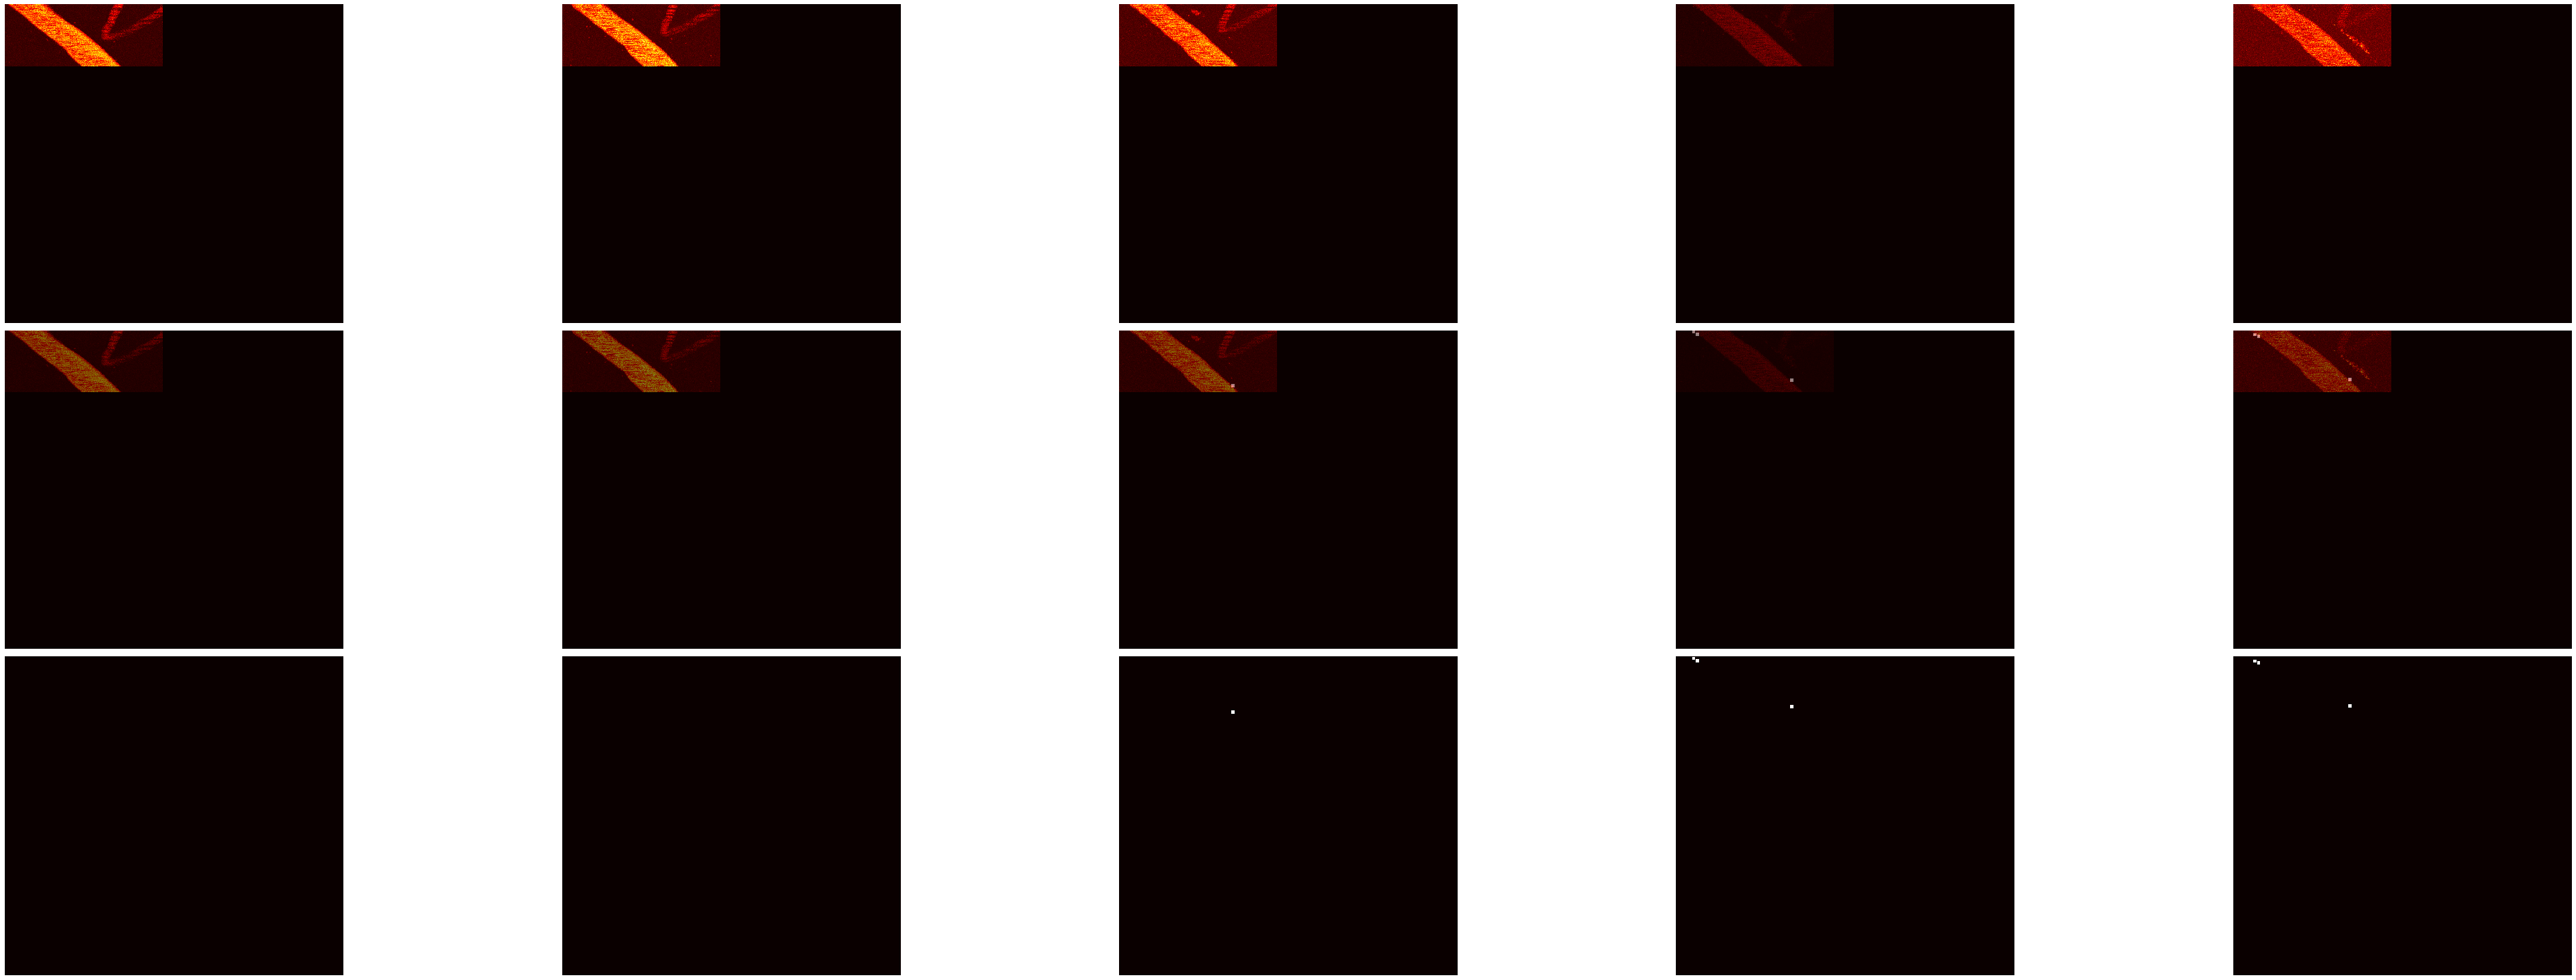

In [5]:
fig, axes = plt.subplots(3, 5, figsize=(60, 20))
random_img_idx = 0
#35-51
#52-57 + 58-63 + 64-69 + 70-75 + 76-81 + 82-87 + 88-93 + 94-99 + 100-105 + 106-111
for i, ax in enumerate(zip(*axes)):
    
    ax[0].imshow(X_test[random_img_idx+i,:,:,0], cmap='hot')
    ax[0].axis('off')
    
    ax[1].imshow(X_test[random_img_idx+i,:,:,0], cmap='hot')
    ax[1].imshow(y_test[random_img_idx+i,:,:,-1], cmap='hot', alpha=.5)
    ax[1].axis('off')
    
    ax[2].imshow(y_test[random_img_idx+i,:,:,-1], cmap='hot')
    ax[2].axis('off')

fig.tight_layout()
plt.show()

In [6]:
Xfives = X_test_resized_pre[0:35,...]
Xones = X_test_resized_pre[35:52,...]
Xsixes = X_test_resized_pre[52:,...]

Xt1 = np.concatenate((Xfives[0::5,...],Xsixes[0::6,...]))
Xt2 = np.concatenate((Xfives[1::5,...],Xsixes[1::6,...]))
Xt3 = np.concatenate((Xfives[2::5,...],Xsixes[2::6,...]))
Xt4 = np.concatenate((Xfives[3::5,...],Xsixes[3::6,...]))
Xt5 = np.concatenate((Xfives[4::5,...],Xsixes[4::6,...]))
Xt6 = Xsixes[5::6,...]

Yfives = y_test_resized[0:35,...]
Yones = y_test_resized[35:52,...]
Ysixes = y_test_resized[52:,...]

Yt1 = np.concatenate((Yfives[0::5,...],Ysixes[0::6,...]))
Yt2 = np.concatenate((Yfives[1::5,...],Ysixes[1::6,...]))
Yt3 = np.concatenate((Yfives[2::5,...],Ysixes[2::6,...]))
Yt4 = np.concatenate((Yfives[3::5,...],Ysixes[3::6,...]))
Yt5 = np.concatenate((Yfives[4::5,...],Ysixes[4::6,...]))
Yt6 = Ysixes[5::6,...]

In [14]:
Xt6.shape

(10, 1024, 1088, 1)

In [28]:
X = [Xt1,Xt2,Xt3,Xt4,Xt5,Xt6]
y = [Yt1,Yt2,Yt3,Yt4,Yt5,Yt6]
OH = tf.keras.models.load_model('./UnetImagenetHorizontalOriginalModel/model.100.h5',compile=False)
OR = tf.keras.models.load_model('./UnetImagenetRotationOriginalModel/model.100.h5',compile=False)
#OS = tf.keras.models.load_model('./UnetImagenetShearOriginalModel/model.100.h5',compile=False)
ORS = tf.keras.models.load_model('./UnetImagenetRotationShearOriginalModel/model.100.h5',compile=False)
ORHV = tf.keras.models.load_model('./UnetImagenetRotationHorizontalVerticalOriginalModel/model.100.h5',compile=False)
ORHVS = tf.keras.models.load_model('./UnetImagenetRotationShearHorizontalVerticalOriginalModel/model.100.h5',compile=False)
#mix = tf.keras.models.load_model('./UnetImagenetMixModel/model.100.h5')
arc = tf.keras.models.load_model('./UnetImagenetArcOriginalModel/model.100.h5',compile=False)
models = [OH,OR,OS,ORS,ORHV,ORHVS]

for model in models:
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss= sm.losses.dice_loss,
        metrics=[f1_score]
    )

for model,i in zip(models,np.arange(1,len(models)+1)):
    print(f'Model {i}:')
    for X_data,y_data,j in zip(X,y,np.arange(1,7)):
        print(f'Time T{j}:')
        results = model.evaluate(X_data, y_data)
        print("test loss, test acc:", results)
    print('All data:')
    results = model.evaluate(X_test_resized_pre, y_test_resized)
    print("test loss, test acc:", results)

Model 1:
Time T1:
17/17 [==============================] - 12s 696ms/sample - loss: 0.9999 - f1-score: 1.3422e-04
test loss, test acc: [0.9998657703399658, 0.00013422249]
Time T2:
17/17 [==============================] - 11s 639ms/sample - loss: 0.9975 - f1-score: 0.0025
test loss, test acc: [0.997479259967804, 0.0025207328]
Time T3:
17/17 [==============================] - 11s 646ms/sample - loss: 0.8820 - f1-score: 0.1180
test loss, test acc: [0.8820226192474365, 0.11797738]
Time T4:
17/17 [==============================] - 11s 661ms/sample - loss: 0.7534 - f1-score: 0.2466
test loss, test acc: [0.7534284591674805, 0.24657151]
Time T5:
17/17 [==============================] - 11s 644ms/sample - loss: 0.6591 - f1-score: 0.3409
test loss, test acc: [0.659138023853302, 0.34086198]
Time T6:
10/10 [==============================] - 7s 671ms/sample - loss: 0.5408 - f1-score: 0.4592
test loss, test acc: [0.5408161878585815, 0.45918378]
All data:
112/112 [==============================] - 72

In [8]:
X = [Xt1,Xt2,Xt3,Xt4,Xt5,Xt6]
y = [Yt1,Yt2,Yt3,Yt4,Yt5,Yt6]
OH = tf.keras.models.load_model('./UnetImagenetHorizontalOriginalModel/model.100.h5',compile=False)
OR = tf.keras.models.load_model('./UnetImagenetRotationOriginalModel/model.100.h5',compile=False)
#OS = tf.keras.models.load_model('./UnetImagenetShearOriginalModel/model.100.h5',compile=False)
ORS = tf.keras.models.load_model('./UnetImagenetRotationShearOriginalModel/model.100.h5',compile=False)
ORHV = tf.keras.models.load_model('./UnetImagenetRotationHorizontalVerticalOriginalModel/model.100.h5',compile=False)
ORHVS = tf.keras.models.load_model('./UnetImagenetRotationShearHorizontalVerticalOriginalModel/model.100.h5',compile=False)
#mix = tf.keras.models.load_model('./UnetImagenetMixModel/model.100.h5')
arc = tf.keras.models.load_model('./UnetImagenetArcOriginalModel/model.100.h5',compile=False)
models = [OH,OR,ORS,ORHV,ORHVS,arc]

for model in models:
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss= sm.losses.dice_loss,
        metrics=[f1_score]
    )

for model,i in zip(models,np.arange(1,len(models)+1)):
    print(f'Model {i}:')
    for X_data,y_data,j in zip(X,y,np.arange(1,7)):
        print(f'Time T{j}:')
        results = model.evaluate(X_data, y_data)
        print("test loss, test acc:", results)
    print('All data:')
    results = model.evaluate(X_test_resized_pre, y_test_resized)
    print("test loss, test acc:", results)

Model 1:
Time T1:
17/17 [==============================] - 12s 680ms/sample - loss: 1.0000 - f1-score: 1.9642e-06
test loss, test acc: [0.9999980330467224, 1.9641886e-06]
Time T2:
17/17 [==============================] - 11s 630ms/sample - loss: 0.9995 - f1-score: 4.7802e-04
test loss, test acc: [0.9995219707489014, 0.0004780155]
Time T3:
17/17 [==============================] - 11s 624ms/sample - loss: 0.8459 - f1-score: 0.1541
test loss, test acc: [0.8459442853927612, 0.15405568]
Time T4:
17/17 [==============================] - 11s 621ms/sample - loss: 0.7931 - f1-score: 0.2069
test loss, test acc: [0.7930562496185303, 0.20694374]
Time T5:
17/17 [==============================] - 11s 625ms/sample - loss: 0.6476 - f1-score: 0.3524
test loss, test acc: [0.6475746631622314, 0.35242534]
Time T6:
10/10 [==============================] - 6s 625ms/sample - loss: 0.5153 - f1-score: 0.4847
test loss, test acc: [0.5153170824050903, 0.48468295]
All data:
112/112 [==============================

# Loss Comparison 3

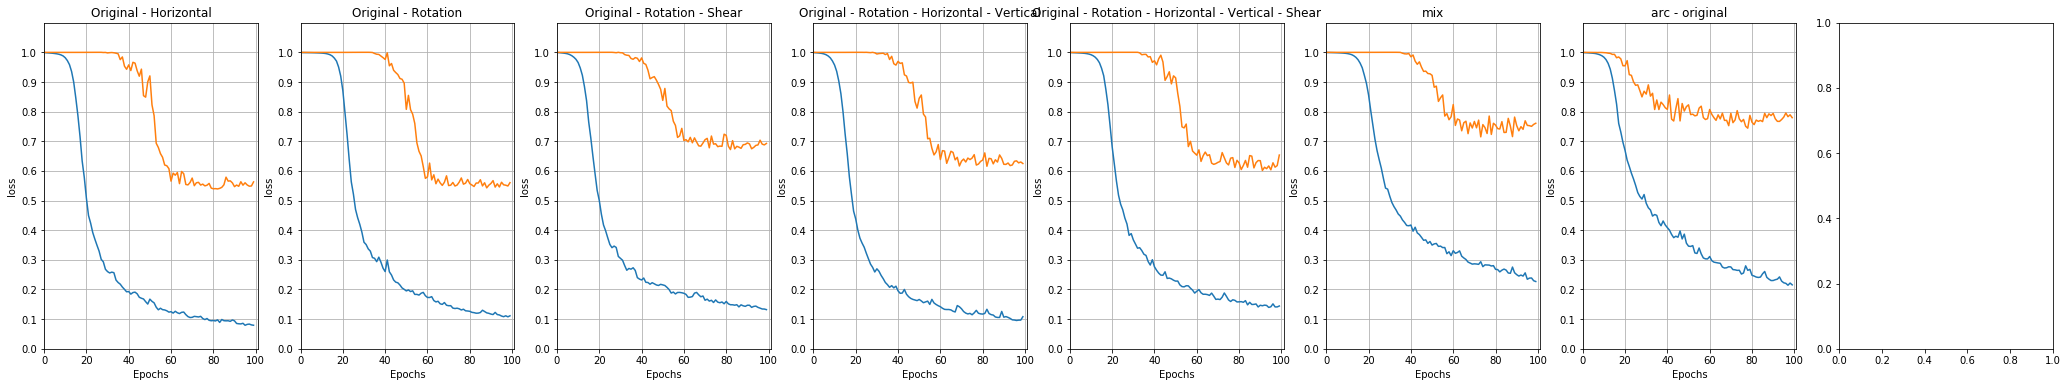

In [2]:
rotation = pd.read_csv('./UnetImagenet45RotationModel/training.log', sep=',', engine='python')
OH = pd.read_csv('./UnetImagenetHorizontalOriginalModel/training.log', sep=',', engine='python')
OR = pd.read_csv('./UnetImagenetRotationOriginalModel/training.log', sep=',', engine='python')
#OS = pd.read_csv('./UnetImagenetShearOriginalModel/training.log', sep=',', engine='python')
ORS = pd.read_csv('./UnetImagenetRotationShearOriginalModel/training.log', sep=',', engine='python')
ORHV = pd.read_csv('./UnetImagenetRotationHorizontalVerticalOriginalModel/training.log', sep=',', engine='python')
ORHVS = pd.read_csv('./UnetImagenetRotationShearHorizontalVerticalOriginalModel/training.log', sep=',', engine='python')
mix = pd.read_csv('./UnetImagenetMixModel/training.log', sep=',', engine='python')
arc = pd.read_csv('./UnetImagenetArcOriginalModel/training.log', sep=',', engine='python')
models = [(OH,'Original - Horizontal'),
          (OR,'Original - Rotation'),
          #(OS,'Original - Shear'),
          (ORS,'Original - Rotation - Shear'),
          (ORHV,'Original - Rotation - Horizontal - Vertical'),
          (ORHVS,'Original - Rotation - Horizontal - Vertical - Shear'),
          (mix,'mix'),
          (arc,'arc - original')]
epochs = np.arange(len(OH['loss']))

fig, ax = plt.subplots(1,8, figsize=(36,6))

for i,model in zip(np.arange(0,len(models)),models):
  ax[i].plot(epochs, model[0]['loss'])
  ax[i].plot(epochs, model[0]['val_loss'])
  ax[i].set_title(model[1])
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel('loss')
  ax[i].set_xlim(0,101)
  ax[i].set_ylim(0,1.1)
  ax[i].set_yticks(np.arange(0,1.1,0.1))
  ax[i].grid()
plt.show()

# Loss Comparison 2

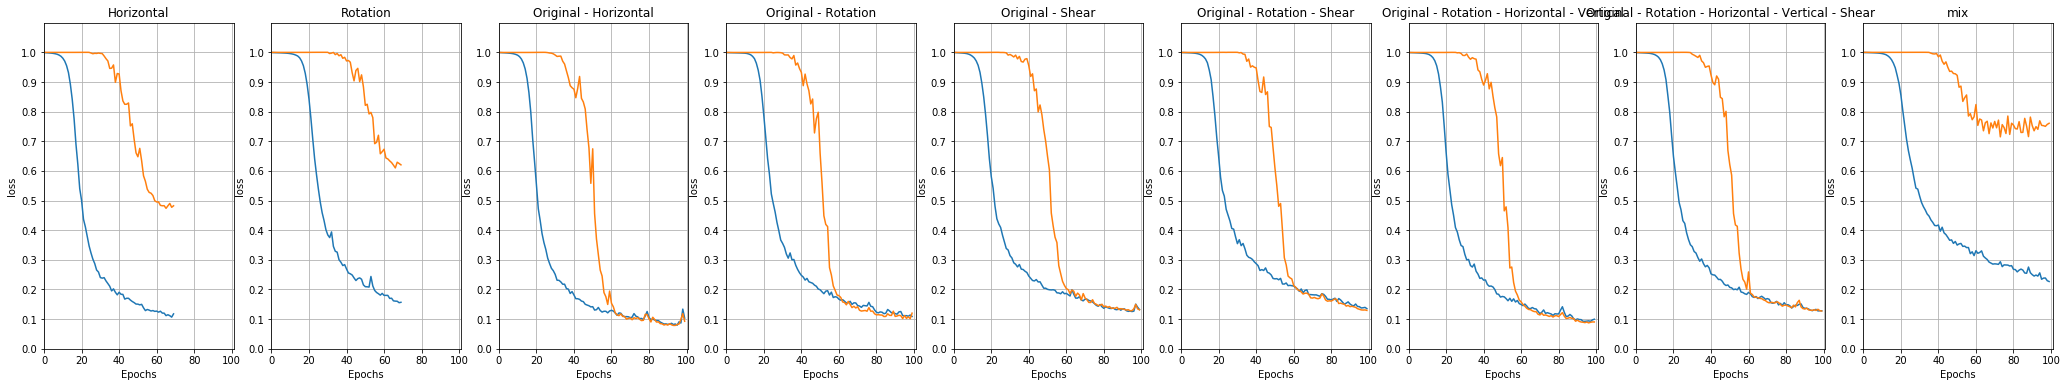

In [12]:
horizontal = pd.read_csv('./UnetImagenetHorizontalModel/training.log', sep=',', engine='python')
rotation = pd.read_csv('./UnetImagenet45RotationModel/training.log', sep=',', engine='python')
OH = pd.read_csv('./UnetImagenetHorizontalOriginalModel/training.log', sep=',', engine='python')
OR = pd.read_csv('./UnetImagenetRotationOriginalModel/training.log', sep=',', engine='python')
OS = pd.read_csv('./UnetImagenetShearOriginalModel/training.log', sep=',', engine='python')
ORS = pd.read_csv('./UnetImagenetRotationShearOriginalModel/training.log', sep=',', engine='python')
ORHV = pd.read_csv('./UnetImagenetRotationHorizontalVerticalOriginalModel/training.log', sep=',', engine='python')
ORHVS = pd.read_csv('./UnetImagenetRotationShearHorizontalVerticalOriginalModel/training.log', sep=',', engine='python')
mix = pd.read_csv('./UnetImagenetMixModel/training.log', sep=',', engine='python')
models = [(OH,'Original - Horizontal'),
          (OR,'Original - Rotation'),
          (OS,'Original - Shear'),
          (ORS,'Original - Rotation - Shear'),
          (ORHV,'Original - Rotation - Horizontal - Vertical'),
          (ORHVS,'Original - Rotation - Horizontal - Vertical - Shear'),
          (mix,'mix')]
models2 = [(horizontal,'Horizontal'),
           (rotation,'Rotation')]
epochs = np.arange(len(OH['loss']))

fig, ax = plt.subplots(1,9, figsize=(36,6))

for i,model in zip(np.arange(0,len(models2)),models2):
  ax[i].plot(np.arange(len(horizontal['loss'])), model[0]['loss'])
  ax[i].plot(np.arange(len(horizontal['loss'])), model[0]['val_loss'])
  ax[i].set_title(model[1])
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel('loss')
  ax[i].set_xlim(0,101)
  ax[i].set_ylim(0,1.1)
  ax[i].set_yticks(np.arange(0,1.1,0.1))
  ax[i].grid()

for i,model in zip(np.arange(len(models2),len(models2)+len(models)),models):
  ax[i].plot(epochs, model[0]['loss'])
  ax[i].plot(epochs, model[0]['val_loss'])
  ax[i].set_title(model[1])
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel('loss')
  ax[i].set_xlim(0,101)
  ax[i].set_ylim(0,1.1)
  ax[i].set_yticks(np.arange(0,1.1,0.1))
  ax[i].grid()
plt.show()

# Arc - Original

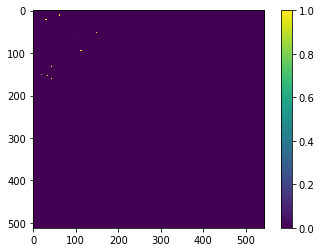

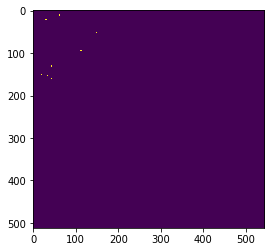

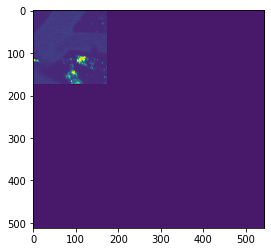

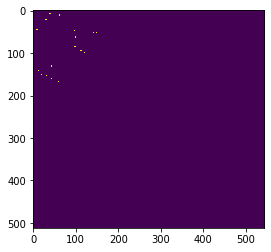

0.6086956521739131

In [14]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.1
plt.imshow(thres[0,...,0])
#plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

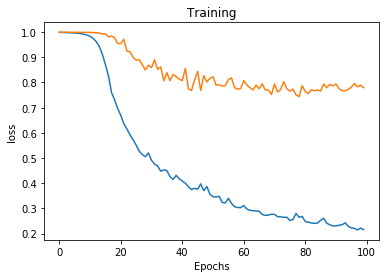

In [15]:
# Loss = sm.losses.dice_loss

epochs = np.arange(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'])
ax.plot(epochs, model_history.history['val_loss'])
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Training')
plt.show()

In [ ]:
avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.02)
plot_dice(avgs,thresholds)

# Mix

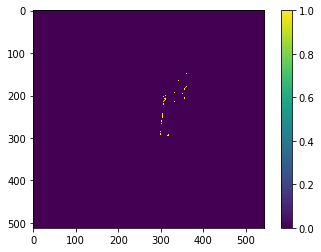

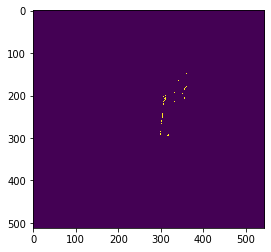

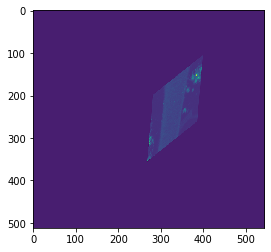

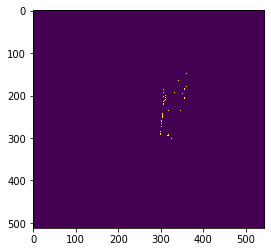

0.8365650969529086

In [18]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.1
plt.imshow(thres[0,...,0])
#plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

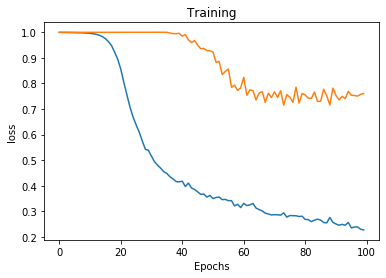

In [14]:
# Loss = sm.losses.dice_loss

epochs = np.arange(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'])
ax.plot(epochs, model_history.history['val_loss'])
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Training')
plt.show()

In [ ]:
avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.02)
plot_dice(avgs,thresholds)

# Original - Horizontal

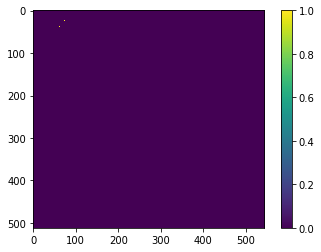

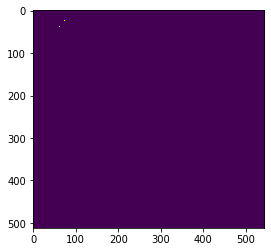

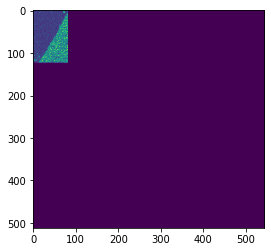

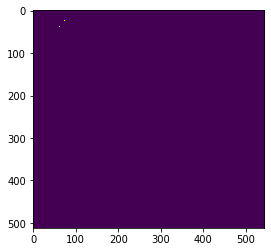

1.0

In [14]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.1
plt.imshow(thres[0,...,0])
#plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

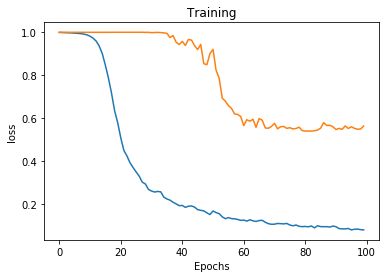

In [15]:
# Loss = sm.losses.dice_loss

epochs = np.arange(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'])
ax.plot(epochs, model_history.history['val_loss'])
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Training')
plt.show()

In [ ]:
avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.02)
plot_dice(avgs,thresholds)

# Original - Rotation - Shear - Horizontal - Vertical

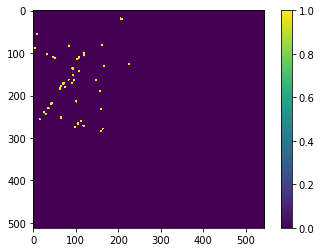

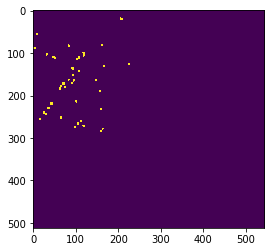

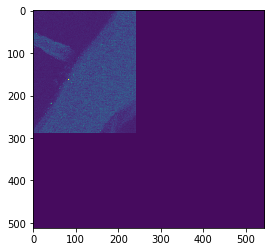

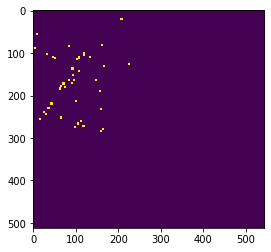

0.9537262542620555

In [47]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.1
plt.imshow(thres[0,...,0])
#plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

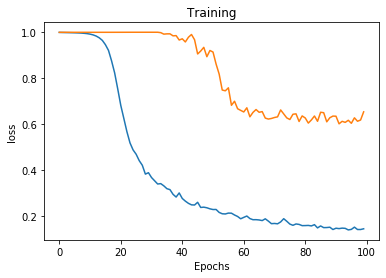

In [48]:
# Loss = sm.losses.dice_loss

epochs = np.arange(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'])
ax.plot(epochs, model_history.history['val_loss'])
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Training')
plt.show()

In [ ]:
avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.02)
plot_dice(avgs,thresholds)

# Original - Shear - Rotation

In [ ]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.1
plt.imshow(thres[0,...,0])
#plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

In [ ]:
# Loss = sm.losses.dice_loss

epochs = np.arange(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'])
ax.plot(epochs, model_history.history['val_loss'])
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Training')
plt.show()

In [ ]:
avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.02)
plot_dice(avgs,thresholds)

# Original - Shear

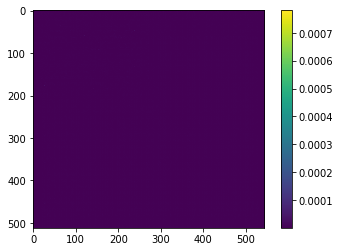

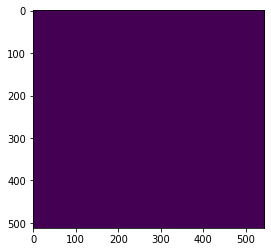

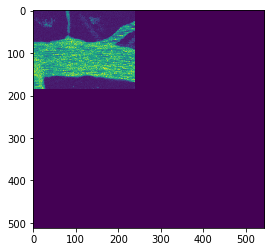

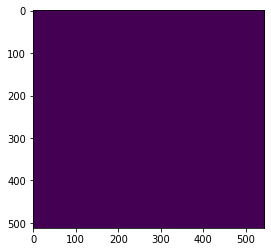

0.0

In [14]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.1
plt.imshow(thres[0,...,0])
#plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

In [15]:
# Loss = sm.losses.dice_loss

epochs = np.arange(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'])
ax.plot(epochs, model_history.history['val_loss'])
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Training')
plt.show()

NameError: name 'model_history' is not defined

In [ ]:
avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.02)
plot_dice(avgs,thresholds)

# Original - Rotation

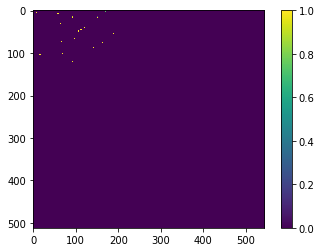

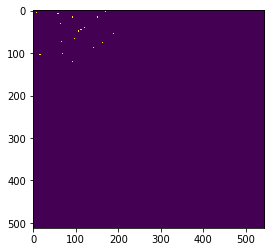

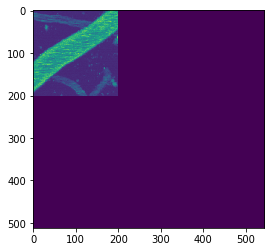

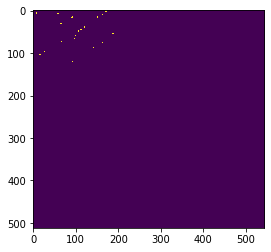

0.8767123287671232

In [13]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.1
plt.imshow(thres[0,...,0])
#plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

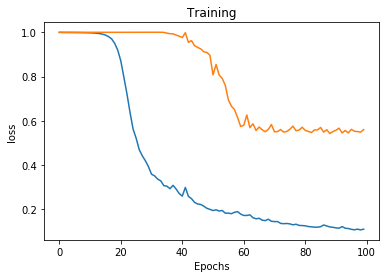

In [14]:
# Loss = sm.losses.dice_loss

epochs = np.arange(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'])
ax.plot(epochs, model_history.history['val_loss'])
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Training')
plt.show()

In [ ]:
avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.02)
plot_dice(avgs,thresholds)

# Original - Horizontal - Vertical - Rotation

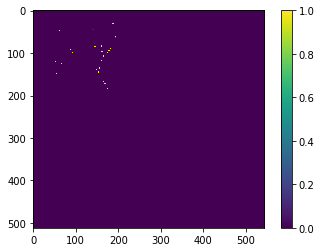

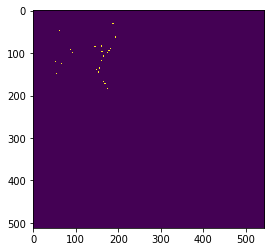

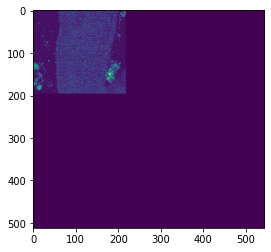

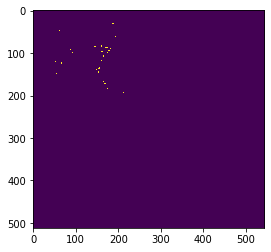

0.8807785888077859

In [16]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.1
plt.imshow(thres[0,...,0])
#plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

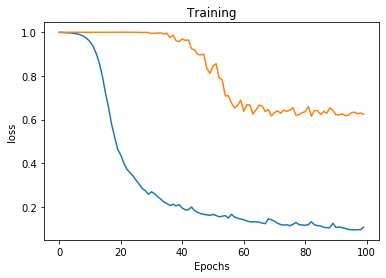

In [18]:
# Loss = sm.losses.dice_loss

epochs = np.arange(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'])
ax.plot(epochs, model_history.history['val_loss'])
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Training')
plt.show()

In [ ]:
avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.02)
plot_dice(avgs,thresholds)

# Rotation

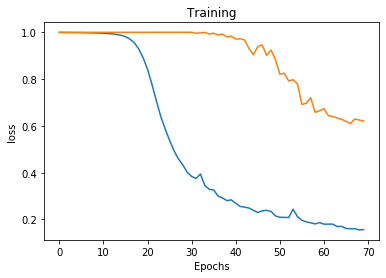

In [42]:
# Loss = sm.losses.dice_loss

epochs = np.arange(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'])
ax.plot(epochs, model_history.history['val_loss'])
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Training')
plt.show()

Computing threshold: 0.9800000000000001

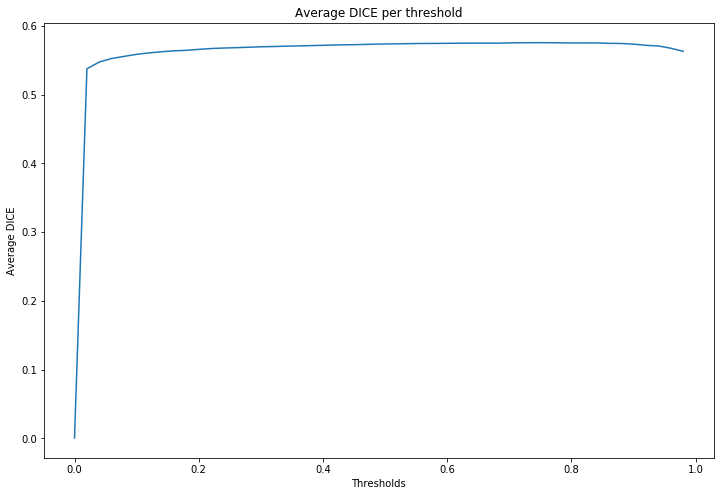

In [43]:
avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.02)
plot_dice(avgs,thresholds)

# Shear Unet Imagenet

In [ ]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.1
plt.imshow(thres[0,...,0])
#plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

In [ ]:
# Loss = sm.losses.dice_loss

epochs = np.arange(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'])
ax.plot(epochs, model_history.history['val_loss'])
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Training')
plt.show()

avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.02)
plot_dice(avgs,thresholds)

# Vertical Unet Imagenet

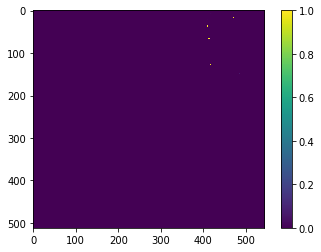

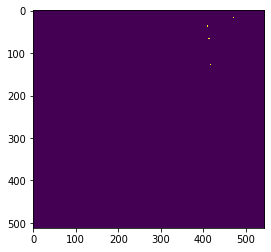

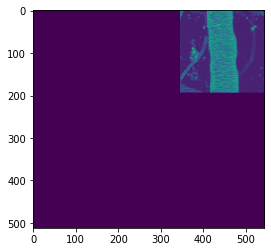

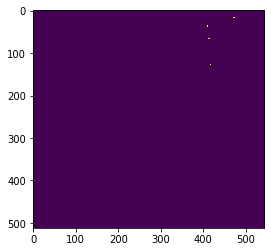

0.9142857142857143

In [29]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.1
plt.imshow(thres[0,...,0])
#plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

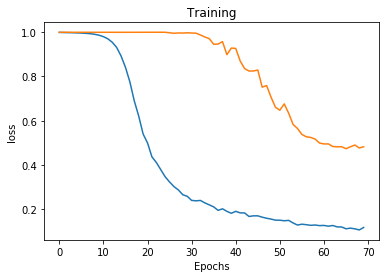

In [30]:
# Loss = sm.losses.dice_loss

epochs = np.arange(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'])
ax.plot(epochs, model_history.history['val_loss'])
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Training')
plt.show()

Computing threshold: 0.9800000000000001

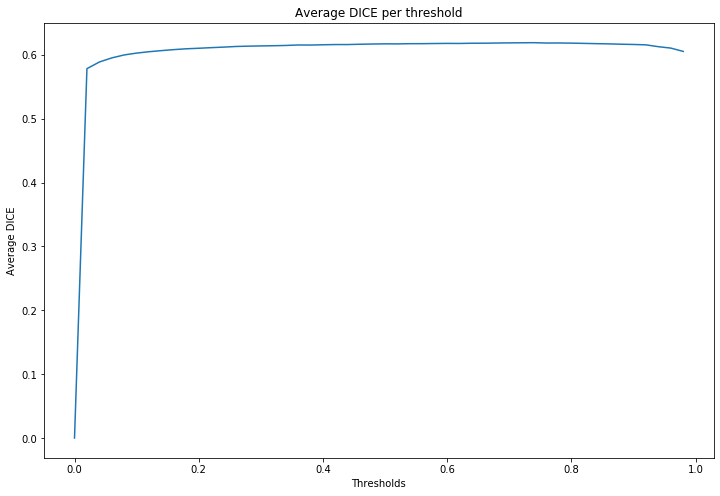

In [31]:
avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.02)
plot_dice(avgs,thresholds)

# Horizontal Unet Imagenet

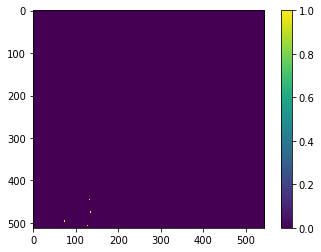

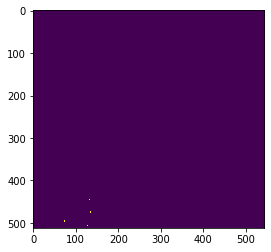

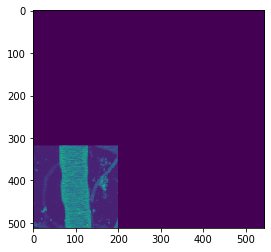

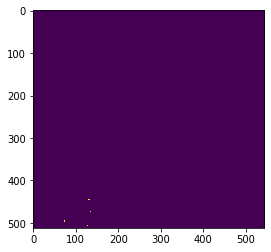

0.9056603773584906

In [15]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.1
plt.imshow(thres[0,...,0])
#plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

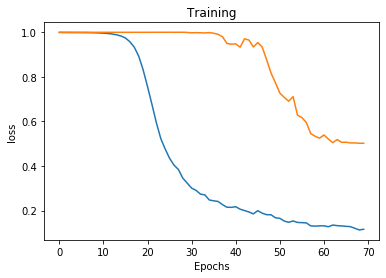

In [17]:
# Loss = sm.losses.dice_loss

epochs = np.arange(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'])
ax.plot(epochs, model_history.history['val_loss'])
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Training')
plt.show()

Computing threshold: 0.9800000000000001

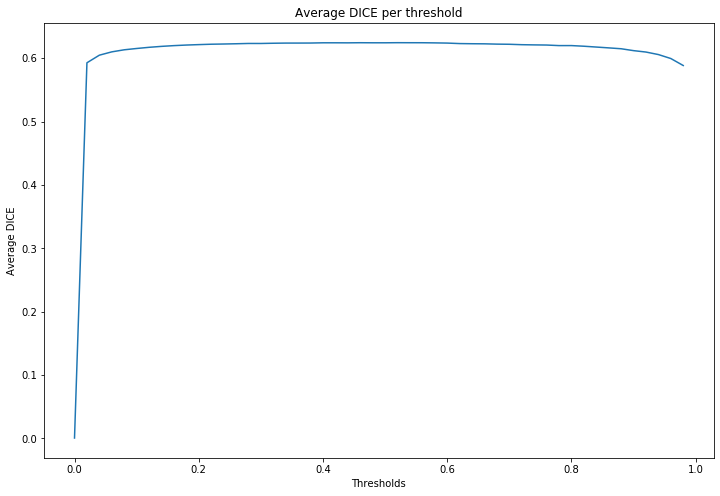

In [18]:
avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.02)
plot_dice(avgs,thresholds)

# Loss comparrison

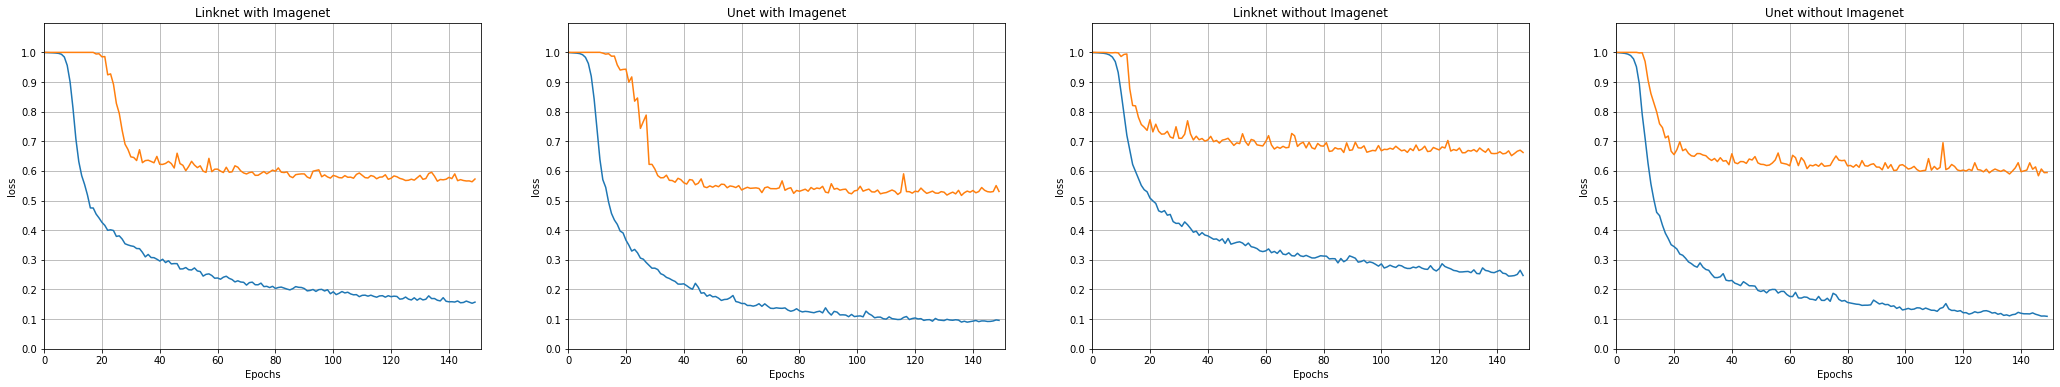

In [ ]:
LnImnet = pd.read_csv('./drive/MyDrive/Transsytosis/LinknetImagenetModel/training.log', sep=',', engine='python')
LnNoImnet = pd.read_csv('./drive/MyDrive/Transsytosis/LinknetNoImagenetModel/training.log', sep=',', engine='python')
UnImnet = pd.read_csv('./drive/MyDrive/Transsytosis/UnetImagenetModel/training.log', sep=',', engine='python')
UnNoImnet = pd.read_csv('./drive/MyDrive/Transsytosis/UnetNoImagenetModel/training.log', sep=',', engine='python')
models = [(LnImnet,'Linknet with Imagenet'),(UnImnet,'Unet with Imagenet'),(LnNoImnet,'Linknet without Imagenet'),(UnNoImnet,'Unet without Imagenet')]
epochs = np.arange(len(LnImnet['loss']))

fig, ax = plt.subplots(1,4, figsize=(36,6))
for i,model in zip(np.arange(0,len(models)),models):
  ax[i].plot(epochs, model[0]['loss'])
  ax[i].plot(epochs, model[0]['val_loss'])
  ax[i].set_title(model[1])
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel('loss')
  ax[i].set_xlim(0,151)
  ax[i].set_ylim(0,1.1)
  ax[i].set_yticks(np.arange(0,1.1,0.1))
  ax[i].grid()
plt.show()

#sm.Linkenet - LR = 0.0001 - 141/150 epochs - imagenet

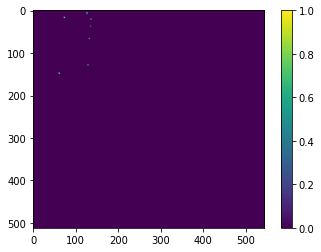

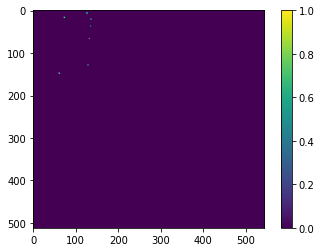

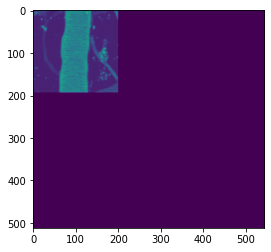

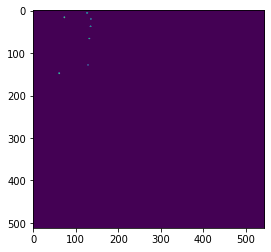

0.896551724137931

In [ ]:
# Model is 141 epochs
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.1
plt.imshow(thres[0,...,0])
plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

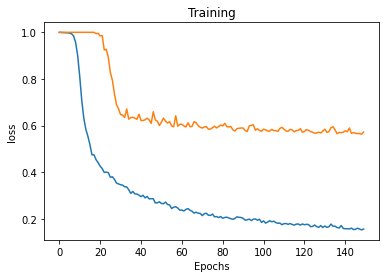

In [ ]:
# Loss = sm.losses.dice_loss

epochs = np.arange(len(log_data['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, log_data['loss'])
ax.plot(epochs, log_data['val_loss'])
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Training')
plt.show()

Computing threshold: 0.98

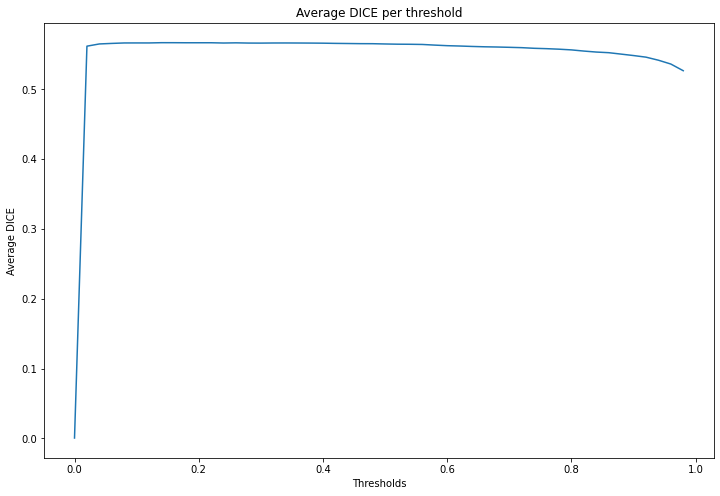

In [ ]:
# Model is 141 epochs
avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.02)
plot_dice(avgs,thresholds)

#sm.Linkenet - LR = 0.0001 - 150 epochs - No imagenet

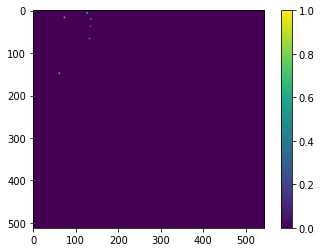

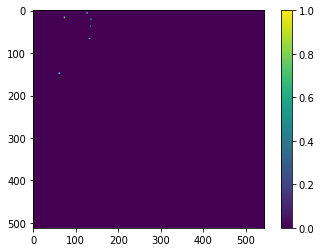

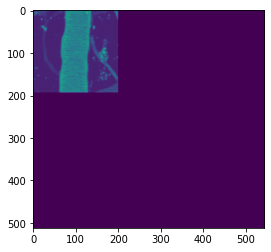

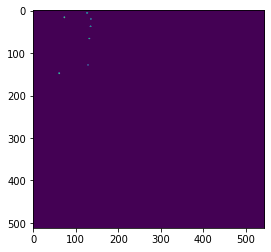

0.8478260869565217

In [ ]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.1
plt.imshow(thres[0,...,0])
plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

In [ ]:
model_input_size = (1024//resize_factor, 1088//resize_factor)

model = sm.Linknet( 
    'resnet18',
    classes=1,
    activation='sigmoid',
    encoder_weights=None, #'imagenet',
    input_shape=(1024//resize_factor, 1088//resize_factor,3),
    decoder_block_type='transpose'
)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss= sm.losses.dice_loss,
    metrics=[f1_score]
)

print(model.summary())

In [ ]:
EPOCHS = 150 #113
BATCH_SIZE = 10
TRAINSET_SIZE = 506
VALSET_SIZE = 104

STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

csv_logger = CSVLogger('./drive/MyDrive/Transsytosis/LinknetNoImagenetModel/training.log', separator=',', append=False)

model_history = model.fit(X_train_resized_pre, 
                          y_train_resized, 
                          epochs=EPOCHS, 
                          batch_size=BATCH_SIZE,
                          validation_data=(X_val_resized_pre, y_val_resized),
                          callbacks=[
                              ModelCheckpoint(filepath=join('./drive/MyDrive/Transsytosis/LinknetNoImagenetModel','model.{epoch:03d}-{val_f1-score:.4f}.h5')),
                              csv_logger
                          ])

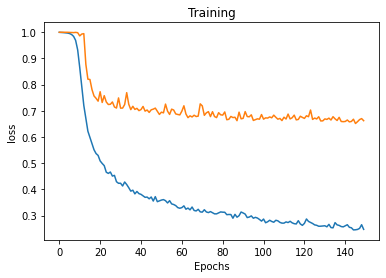

In [ ]:
# Loss = sm.losses.dice_loss

epochs = np.arange(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'])
ax.plot(epochs, model_history.history['val_loss'])
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Training')
plt.show()

Computing threshold: 0.98

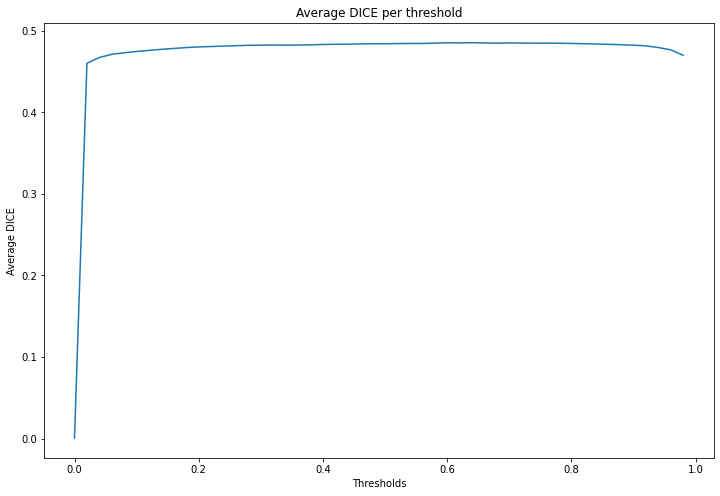

In [ ]:
avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.02)
plot_dice(avgs,thresholds)

In [ ]:
model.save_weights('./drive/MyDrive/Transsytosis/LinknetNoImagenetModel/ModelWeights')

#sm.unet - LR = 0.0001 - 150 epochs - No imagenet

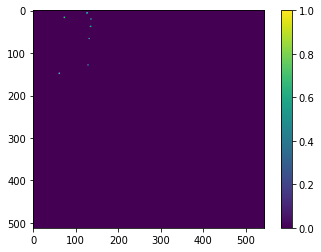

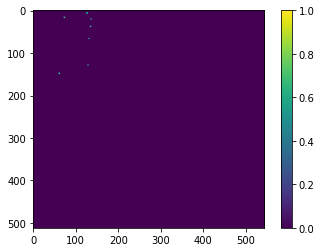

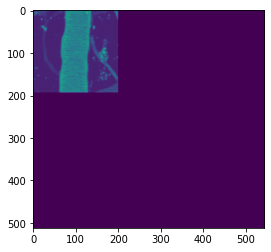

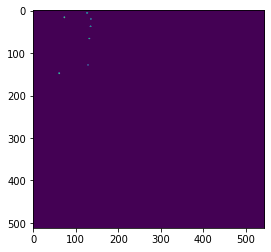

0.9247311827956989

In [ ]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.1
plt.imshow(thres[0,...,0])
plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

In [ ]:
model_input_size = (1024//resize_factor, 1088//resize_factor)

model = sm.Unet( 
    'resnet18',
    classes=1,
    activation='sigmoid',
    encoder_weights= None, #'imagenet',
    input_shape=(1024//resize_factor, 1088//resize_factor,3),
    decoder_block_type='transpose'
)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss= sm.losses.dice_loss,
    metrics=[f1_score]
)

model.load_weights('./drive/MyDrive/Transsytosis/UnetNoImagenetModel/ModelWeights')

In [ ]:
EPOCHS = 150 #113
BATCH_SIZE = 10
TRAINSET_SIZE = 506
VALSET_SIZE = 104

STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

csv_logger = CSVLogger('./drive/MyDrive/Transsytosis/UnetNoImagenetModel/training.log', separator=',', append=False)

model_history = model.fit(X_train_resized_pre, 
                          y_train_resized, 
                          epochs=EPOCHS, 
                          batch_size=BATCH_SIZE,
                          validation_data=(X_val_resized_pre, y_val_resized),
                          callbacks=[
                              ModelCheckpoint(filepath=join('./drive/MyDrive/Transsytosis/UnetNoImagenetModel','model.{epoch:03d}-{val_f1-score:.4f}.h5')),
                              csv_logger
                          ])

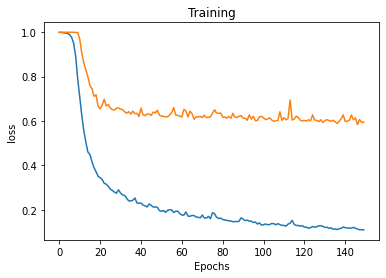

In [ ]:
# Loss = sm.losses.dice_loss

epochs = np.arange(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'])
ax.plot(epochs, model_history.history['val_loss'])
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Training')
plt.show()

Computing threshold: 0.98

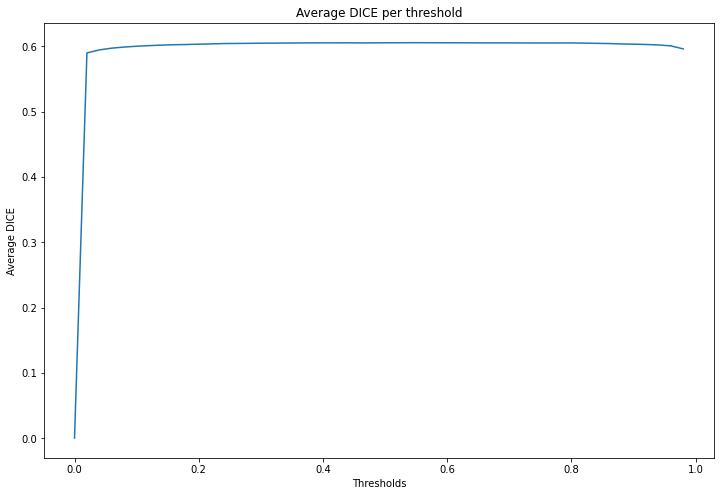

In [ ]:
avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.02)
plot_dice(avgs,thresholds)

In [ ]:
model.save_weights('./drive/MyDrive/Transsytosis/UnetNoImagenetModel/ModelWeights')

#sm.unet - LR = 0.0001 - 150 epochs - imagenet

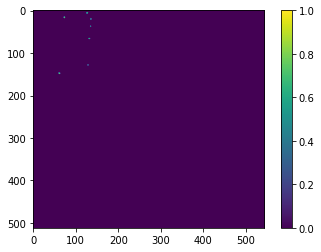

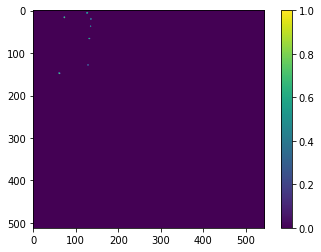

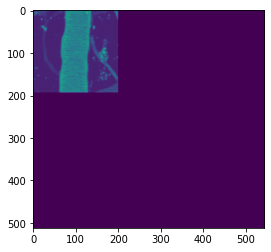

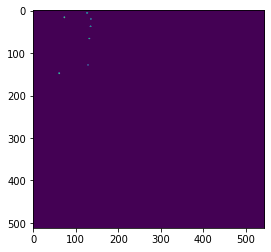

0.946236559139785

In [ ]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.02
plt.imshow(thres[0,...,0])
plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

In [ ]:
model_input_size = (1024//resize_factor, 1088//resize_factor)

model = sm.Unet( 
    'resnet18',
    classes=1,
    activation='sigmoid',
    encoder_weights= 'imagenet',#'none', 
    input_shape=(1024//resize_factor, 1088//resize_factor,3),
    decoder_block_type='transpose'
)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss= sm.losses.dice_loss,
    metrics=[f1_score]
)

model.load_weights('./drive/MyDrive/Transsytosis/UnetImagenetModel/ModelWeights')

In [ ]:
EPOCHS = 150 #113
BATCH_SIZE = 10
TRAINSET_SIZE = 506
VALSET_SIZE = 104

STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

csv_logger = CSVLogger('./drive/MyDrive/Transsytosis/UnetImagenetModel/training.log', separator=',', append=False)

model_history = model.fit(X_train_resized_pre, 
                          y_train_resized, 
                          epochs=EPOCHS, 
                          batch_size=BATCH_SIZE,
                          validation_data=(X_val_resized_pre, y_val_resized),
                          callbacks=[
                              ModelCheckpoint(filepath=join('./drive/MyDrive/Transsytosis/UnetImagenetModel','model.{epoch:03d}-{val_f1-score:.4f}.h5')),
                              csv_logger
                          ])

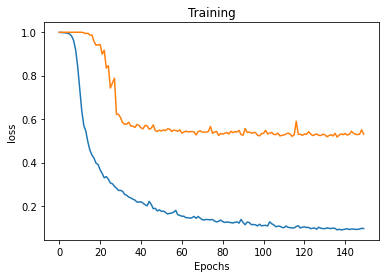

In [ ]:
# Loss = sm.losses.dice_loss

epochs = np.arange(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'])
ax.plot(epochs, model_history.history['val_loss'])
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Training')
plt.show()

Computing threshold: 0.98

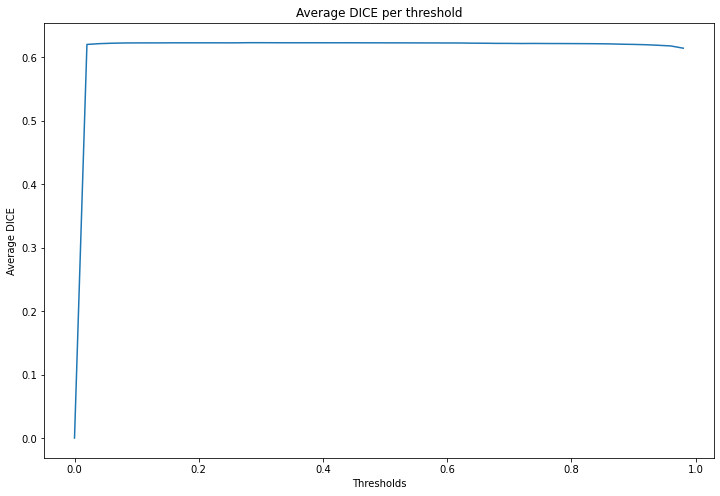

In [ ]:
avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.02)
plot_dice(avgs,thresholds)

In [ ]:
model.save_weights('./drive/MyDrive/Transsytosis/UnetImagenetModel/ModelWeights')

# sm.unet - LR = 0.001

In [ ]:
model = sm.Unet( 
    'resnet18',
    classes=1,
    activation='sigmoid',
    encoder_weights='imagenet',
    input_shape=(1024//resize_factor, 1088//resize_factor,3),
    decoder_block_type='transpose'
)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=sm.losses.dice_loss,
    metrics=[f1_score]
)

model.load_weights('./drive/MyDrive/Transsytosis/unetLR0001DiceWeights')

# EPOCHS = 30 #113
# BATCH_SIZE = 10
# TRAINSET_SIZE = 506
# VALSET_SIZE = 104

44924928/44920640 [==============================] - 2s 0us/step


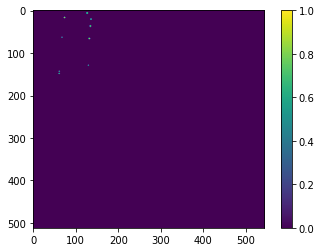

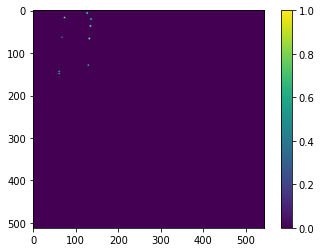

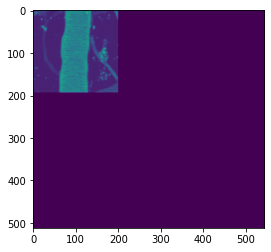

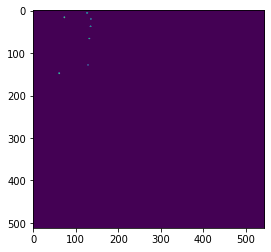

0.6190476190476191

In [ ]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.05
plt.imshow(thres[0,...,0])
plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

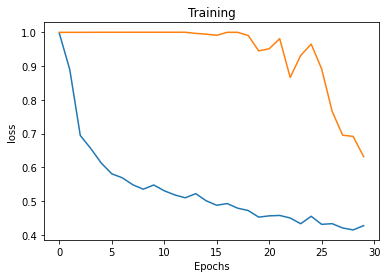

In [ ]:
# Loss = sm.losses.dice_loss

epochs = np.arange(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'])
ax.plot(epochs, model_history.history['val_loss'])
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Training')
plt.show()

Computing threshold: 0.9500000000000001

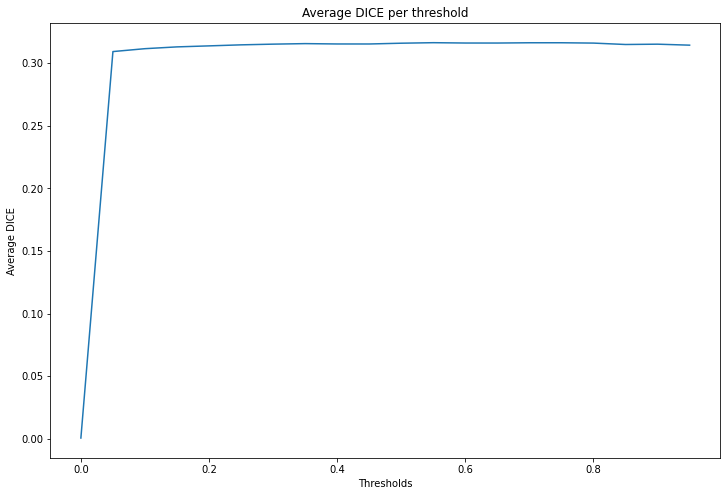

In [ ]:
avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.05)
plot_dice(avgs,thresholds)

In [ ]:
model.save_weights('./drive/MyDrive/Transsytosis/unetLR0001DiceWeights')

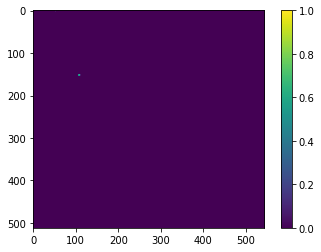

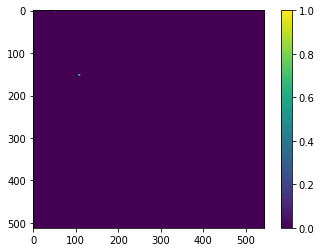

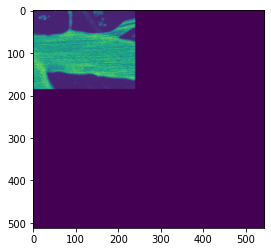

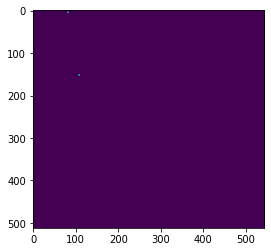

0.5625

In [ ]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.05
plt.imshow(thres[0,...,0])
plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

# sm.unet - LR = 0.001 - BinaryCrossentropy

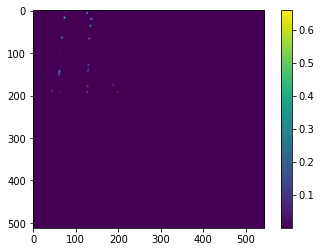

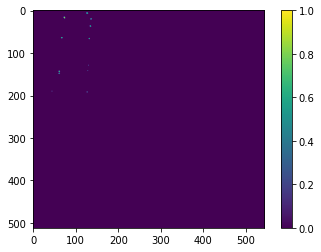

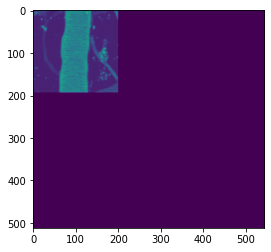

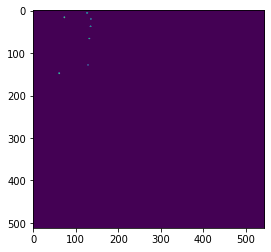

0.56

In [ ]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.3
plt.imshow(thres[0,...,0])
plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

In [ ]:
model = sm.Unet( 
    'resnet18',
    classes=1,
    activation='sigmoid',
    encoder_weights='imagenet',
    input_shape=(1024//resize_factor, 1088//resize_factor,3),
    decoder_block_type='transpose'
)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=[f1_score]
)

model.load_weights('./drive/MyDrive/Transsytosis/unetLR0001CrossEntropyWeights')

# EPOCHS = 30 #113
# BATCH_SIZE = 10
# TRAINSET_SIZE = 506
# VALSET_SIZE = 104

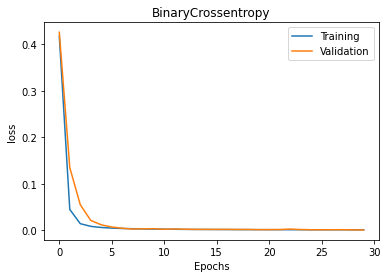

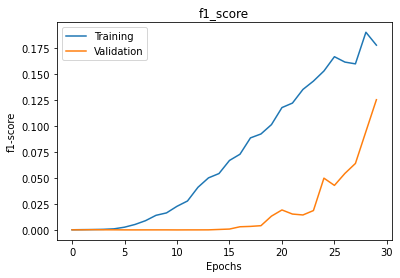

In [ ]:
# Loss = BinaryCrossEntropy

epochs = np.arange(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'], label='Training')
ax.plot(epochs, model_history.history['val_loss'], label='Validation')
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('BinaryCrossentropy')
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['f1-score'],label='Training')
ax.plot(epochs, model_history.history['val_f1-score'],label='Validation')
ax.set_xlabel('Epochs')
ax.set_ylabel('f1-score')
ax.set_title('f1_score')
ax.legend()
plt.show()

Computing threshold: 0.9500000000000001

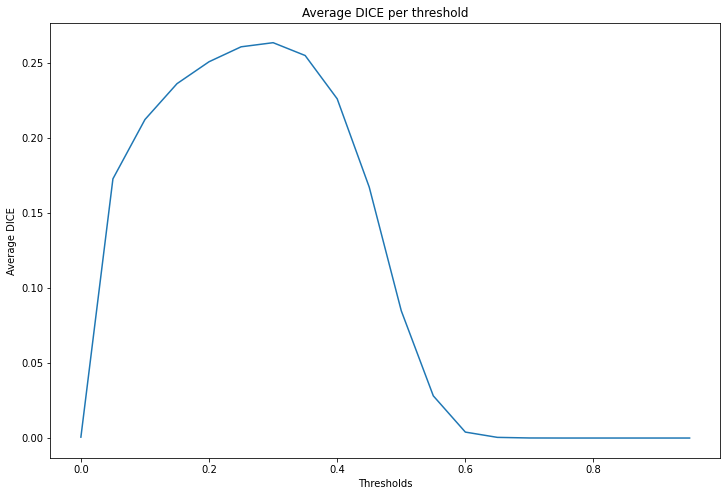

In [ ]:
avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.05)
plot_dice(avgs,thresholds)

In [ ]:
model.save_weights('./drive/MyDrive/Transsytosis/unetLR0001BinaryCrossentropyWeights')

# sm.Linknet - LR = 0.001

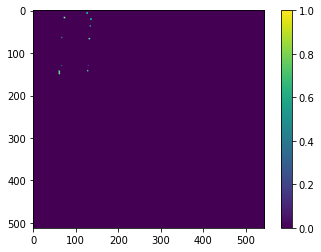

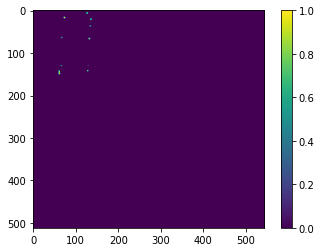

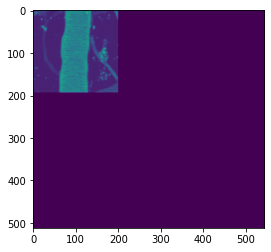

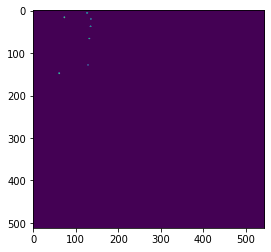

0.5379310344827586

In [ ]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.1
plt.imshow(thres[0,...,0])
plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

In [ ]:
model_input_size = (1024//resize_factor, 1088//resize_factor)

model = sm.Linknet( 
    'resnet18',
    classes=1,
    activation='sigmoid',
    encoder_weights='imagenet',
    input_shape=(1024//resize_factor, 1088//resize_factor,3),
    decoder_block_type='transpose'
)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=sm.losses.dice_loss,
    metrics=[f1_score]
)

print(model.summary())


# EPOCHS = 30 #113
# BATCH_SIZE = 10
# TRAINSET_SIZE = 506
# VALSET_SIZE = 104

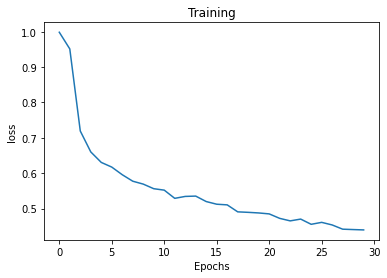

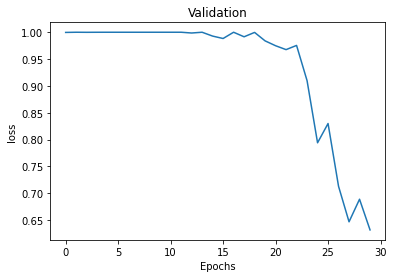

In [ ]:
# Loss = sm.losses.dice_loss

epochs = np.arange(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'])
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Training')
plt.show()

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['val_loss'])
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Validation')
plt.show()

Computing threshold: 0.9500000000000001

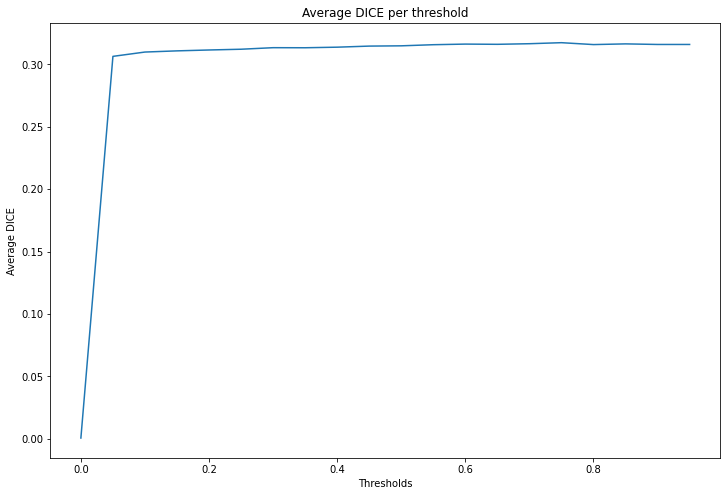

In [ ]:
avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.05)
plot_dice(avgs,thresholds)

In [ ]:
model.save_weights('./drive/MyDrive/Transsytosis/LinknetLR0001DiceWeights')

# sm.Linknet - LR = 0.001 - BinaryCrossentropy

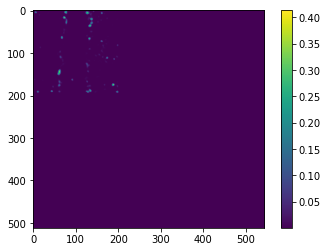

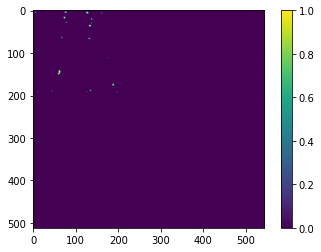

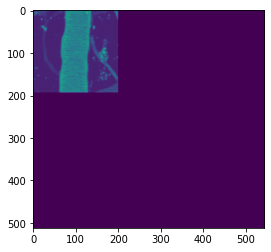

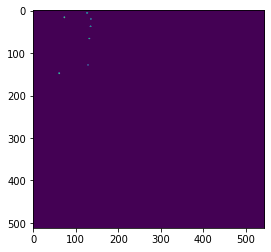

0.3402061855670103

In [ ]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

thres = pred > 0.2
plt.imshow(thres[0,...,0])
plt.colorbar()
plt.show()

plt.imshow(data[0,...,0])
plt.show()

plt.imshow(y_train_resized[img,...,0])
plt.show()

get_dice(thres[0,...,0], y_train_resized[img,...,0])

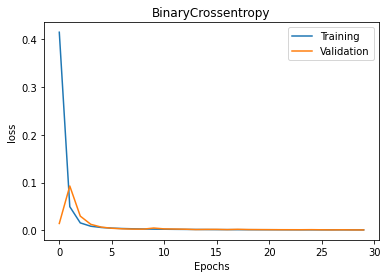

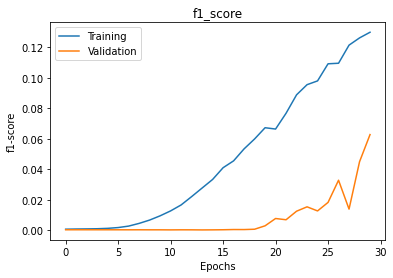

In [ ]:
# Loss = BinaryCrossEntropy

epochs = np.arange(len(model_history.history['loss']))

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['loss'], label='Training')
ax.plot(epochs, model_history.history['val_loss'], label='Validation')
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('BinaryCrossentropy')
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(epochs, model_history.history['f1-score'],label='Training')
ax.plot(epochs, model_history.history['val_f1-score'],label='Validation')
ax.set_xlabel('Epochs')
ax.set_ylabel('f1-score')
ax.set_title('f1_score')
ax.legend()
plt.show()

Computing threshold: 0.9500000000000001

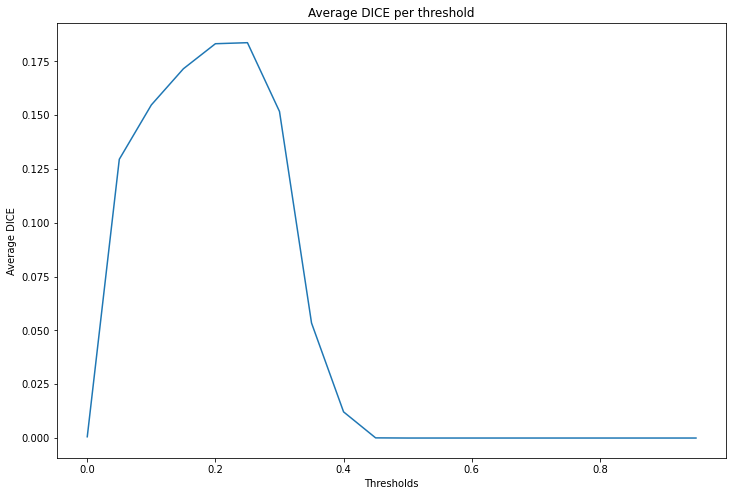

In [ ]:
avgs, thresholds = threshold_accuracies(X_train_resized_pre,y_train_resized,0,1,0.05)
plot_dice(avgs,thresholds)

In [ ]:
model.save_weights('./drive/MyDrive/Transsytosis/LinknetLR0001BinaryCrossentropyWeights')